# Validation of Potentials

To ensure that our fitted ACE potentials provide reliable predictions, it is crucial to validate them against reference data from DFT calculations or experiments. In this notebook, we will use previously fitted ACE potential(s) to compute key properties—namely, energies, equilibrium volumes, and bulk moduli—for various phases. 

This validation step corresponds to Level 2 validation from the schematic, and is essential to confirm that the potentials capture the underlying physics accurately and can be confidently used for further simulations and analysis.


<img src="img/validation_schematic.png" alt="Validation schematic" width="700"/>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pyiron_nodes.atomistic.properties.murnaghan import * 

### ACE and GRACE Calculators

For simulations involving ACE and GRACE potentials, having ASE-compatible calculators is essential. In our workflow, these calculators are implemented as Pyiron nodes.

In [2]:
from pyiron_nodes.atomistic.mlips.calculator.ace import Ace

# provide the file path to the ACE potential
potential_path = "potentials/Better_potential.yace"
potential_path = "potentials/Ca_Mg_linear_potential.yace"


ace = Ace(potential_path)

Several pre-fitted GRACE foundation models are available for use. You can choose from the following options:

- `MP_GRACE_1L_r6_4Nov2024`
- `MP_GRACE_1L_r6_07Nov2024`
- `MP_GRACE_2L_r6_11Nov2024`
- `MP_GRACE_2L_r5_4Nov2024`
- `MP_GRACE_2L_r5_07Nov2024`
- `GRACE_2L_OAM_28Jan25`
- `GRACE-1L-OAM_2Feb25`

For further details about the GRACE foundation models, please refer to the [Grace documentation](https://gracemaker.readthedocs.io/en/latest/gracemaker/foundation/).

Note that you only need to provide the model string as an argument—the associated potential files will be downloaded at runtime.


In [3]:
from pyiron_nodes.atomistic.mlips.calculator.grace import Grace


grace = Grace('GRACE-FS-OMAT')

In [4]:
# set one of ace or grace calcs as the default calculator for further calculations

# calc = grace_calc
calc = ace

## Basic workflow for validation of energy-volume curves

In the current notebook, we will utilize the defined models and predict the energies, volumes, and bulk moduli of certain phases. We accomplish this through a series of workflow nodes that perform the following tasks:

1. **Build the Structure:**  
   Using a minimal input (such as an element string, e.g. `"Ca"`), we generate a bulk atomic structure using the `Bulk` node from `pyiron_nodes`. This node creates the structure based on common crystallographic data.

2. **Structure Optimization:**  
   The generated structure is optimized using the chosen calculator. In this step, the atomic positions and cell parameters are relaxed (using algorithms such as BFGS) until the forces are below a specified threshold. This optimization is critical to ensure that the following energy-volume calculations are accurate.

3. **Energy–Volume (EV) Curve Calculation:**  
   Once optimized, the workflow computes an EV curve by scaling the unit cell around the equilibrium volume. For each scaled structure, the potential energy is calculated.

4. **Plotting:**  
   Optionally, the EV curve and the fitted EOS are plotted. This allows us to visually assess the smoothness of the potential energy landscape predicted by the models.

5. **Fitting the Birch–Murnaghan Equation of State:**  
   The computed EV curve is fitted to the Birch–Murnaghan equation of state (EOS). This fitting yields important physical quantities:
   - **E0:** Equilibrium energy
   - **V0:** Equilibrium volume
   - **B0:** Bulk modulus  
   These parameters are essential for comparing the ACE potential predictions with DFT or experimental reference data.




#### Define structure

Use an in-built node `from pyiron_nodes.atomistic.structure.build import Bulk` to generate atomic structures. For single-element phases, the node automatically generates the ground-state structure for the given element with a rough guess for the lattice parameter.

Execute `Bulk?` for more details

In [5]:
from pyiron_nodes.atomistic.structure.build import Bulk 
# Bulk?

In [6]:
bulk_struc = Bulk("Ca", cubic=True)
bulk_struc = bulk_struc.pull()
bulk_struc

Ca: [0. 0. 0.]
Ca: [0.   2.79 2.79]
Ca: [2.79 0.   2.79]
Ca: [2.79 2.79 0.  ]
tags: 
    indices: [0 0 0 0]
pbc: [ True  True  True]
cell: 
Cell([5.58, 5.58, 5.58])

#### OptimizeStructure

The generated structure may not be in equilibirum. Before proceeding further, it is important that the structure is optimized.

We use a predefined `OptimizeStructure` function to relax both the atomic positions and cell vectors.

In [7]:
opt_struc = OptimizeStructure(bulk_struc, calc)
opt_struc = opt_struc.pull()
opt_struc

/home/poul/pyiron/DPG-tutorial-2025/pyiron_nodes/atomistic/properties/murnaghan.py:34: FutureWarning: Import ExpCellFilter from ase.filters
  constrained_structure = ExpCellFilter(structure)
2025-03-13 23:15:26,540 - pyiron_log - DEBUG - Not supported parameter used!


      Step     Time          Energy          fmax
BFGS:    0 23:15:26       -7.668156        5.009981


2025-03-13 23:15:27,008 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    1 23:15:27       -8.239410        0.328952


2025-03-13 23:15:27,023 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    2 23:15:27       -8.241034        0.098147


2025-03-13 23:15:27,037 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    3 23:15:27       -8.241197        0.001373


Ca: [-1.50226604e-17 -1.46630705e-17 -1.50234435e-17]
Ca: [-3.19629470e-17  2.59979248e+00  2.59979248e+00]
Ca: [ 2.59979248e+00 -3.12790331e-17  2.59979248e+00]
Ca: [ 2.59979248e+00  2.59979248e+00 -3.12975990e-17]
tags: 
    indices: [0 0 0 0]
pbc: [ True  True  True]
cell: 
Cell([[5.199584969401751, -1.8839972878328246e-17, -1.843982207056019e-17], [-1.7878440102393573e-17, 5.199584969401751, -1.86633521137507e-17], [-1.9191242607778077e-17, -1.865912664382563e-17, 5.199584969401751]])

#### Calculate EV Curve

With the optimized structure (denoted as `opt_struc`) in hand, we proceed to calculate the energy-volume (EV) curves. These curves provide essential information about the structure, including the equilibrium energy, equilibrium volume (and the corresponding lattice parameter), as well as the bulk modulus. Such properties can be directly compared to DFT results or experimental data.

We utilize a predefined node, `CalculateEVCurve`, to generate a DataFrame containing the atomic volumes and their corresponding energies. This node offers several parameters that allow you to fine-tune the volume range and the number of calculation points, ensuring a detailed and accurate EV curve.


In [8]:
ev_curve_df = CalculateEVCurve(
                                structure=opt_struc, 
                                calculator=calc, 
                                vol_range = 0.1,
                                num_of_points = 11,
                                optimize = False,
                            )

ev_curve_df = ev_curve_df.pull()
ev_curve_df

2025-03-13 23:15:27,069 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,071 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,073 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,077 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,082 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,084 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,085 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,087 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,091 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,092 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,094 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,096 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,100 - pyiron_log - DEBUG - Not supported parameter used!

,volume,energy,ase_atoms
0,25.619673,-1.609074,"[Atom('Ca', [-1.352039434807592e-17, -1.319676..."
1,27.365887,-1.783021,"[Atom('Ca', [-1.382084755581094e-17, -1.349002..."
2,29.189698,-1.913245,"[Atom('Ca', [-1.412130076354596e-17, -1.378328..."
3,31.092794,-1.999183,"[Atom('Ca', [-1.4421753971280982e-17, -1.40765..."
4,33.076860,-2.046011,"[Atom('Ca', [-1.4722207179016003e-17, -1.43698..."
5,35.143584,-2.060299,"[Atom('Ca', [-1.5022660386751022e-17, -1.46630..."
6,37.294652,-2.047706,"[Atom('Ca', [-1.5323113594486043e-17, -1.49563..."
7,39.531752,-2.013007,"[Atom('Ca', [-1.562356680222106e-17, -1.524959..."
8,41.856571,-1.960154,"[Atom('Ca', [-1.5924020009956083e-17, -1.55428..."
9,44.270794,-1.892346,"[Atom('Ca', [-1.6224473217691104e-17, -1.58361..."


#### Plotting the EV curve

The node`PlotEVCurve` allows us to plot the dataframe obtained in the previous step. Visualizing the EV curves provides an indication of the smoothness of the predicted potential energy surface.

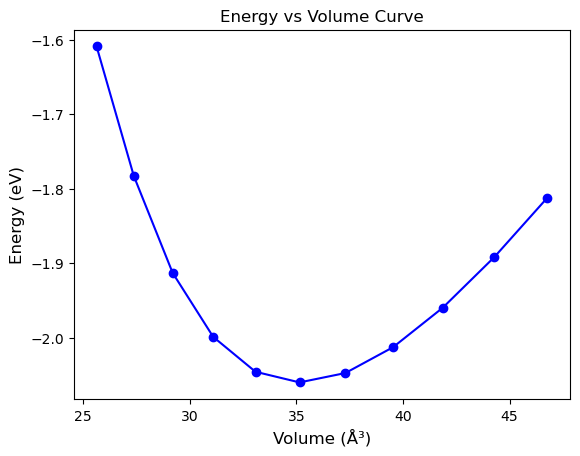

In [9]:
ev_plot = PlotEVCurve(ev_curve_df = ev_curve_df)
ev_plot.pull();

#### Fit the EV data to the Birch-Murnaghan equation of state

The Birch-Murnaghan EOS is given by,  

$E(V) = E_0 + \frac{9V_0 B_0}{16} \Bigg\{ \Bigg[\frac{V_0}{V}^{\frac{2}{3}} - 1\Bigg]^3 B_0^\prime + \Bigg[ \frac{V_0}{V}^{\frac{2}{3}} - 1\Bigg]^2 \Bigg[ \frac{V_0}{V}^{\frac{2}{3}} \Bigg] \Bigg\}$.


By fitting the EV data to this equation, we can extract the key parameters: the equilibrium energy $E_0$, equilibrium volume $V_0$, bulk modulus $B_0$, and its pressure derivative $B_0'$. This is achieved by invoking the node `FitBirchMurnaghanEOS` and supplying the EV data as input.

In [10]:
fit = FitBirchMurnaghanEOS(ev_curve_df)
E0, V0, B0 = fit.pull()

print(f"E0={E0}, V0={V0}, B0={B0}")

E0=-2.059515179170665, V0=35.23129380601454, B0=33.372039111529375


## Combine All in a Workflow

The individual functions described above can be seamlessly integrated into a single workflow using the `pyiron_workflow.Workflow` object. All the steps—from structure generation and optimization to EV curve calculation and EOS fitting—are encapsulated within the `make_murnaghan_workflow` node.

To create the complete workflow, simply provide the element name (which is used to build the structure) and the potential path (which selects the appropriate calculator). This unified workflow streamlines the validation process, making it straightforward to assess the quality of your potentials.


2025-03-13 23:15:27,346 - pyiron_log - INFO - Assigning a channel with the label name to the io key build_structure__name
2025-03-13 23:15:27,347 - pyiron_log - INFO - Assigning a channel with the label crystalstructure to the io key build_structure__crystalstructure
2025-03-13 23:15:27,349 - pyiron_log - INFO - Assigning a channel with the label a to the io key build_structure__a
2025-03-13 23:15:27,350 - pyiron_log - INFO - Assigning a channel with the label c to the io key build_structure__c
2025-03-13 23:15:27,351 - pyiron_log - INFO - Assigning a channel with the label c_over_a to the io key build_structure__c_over_a
2025-03-13 23:15:27,352 - pyiron_log - INFO - Assigning a channel with the label u to the io key build_structure__u
2025-03-13 23:15:27,354 - pyiron_log - INFO - Assigning a channel with the label orthorhombic to the io key build_structure__orthorhombic
2025-03-13 23:15:27,355 - pyiron_log - INFO - Assigning a channel with the label cubic to the io key build_structure

      Step     Time          Energy          fmax
BFGS:    0 23:15:27       -1.917039        1.252495


2025-03-13 23:15:27,413 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    1 23:15:27       -1.977823        0.986753


2025-03-13 23:15:27,426 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    2 23:15:27       -2.049656        0.413941


2025-03-13 23:15:27,442 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    3 23:15:27       -2.059834        0.082518


2025-03-13 23:15:27,454 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    4 23:15:27       -2.060297        0.005461


2025-03-13 23:15:27,463 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,465 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,468 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,470 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,472 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,474 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,475 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,479 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,481 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,482 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,483 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,485 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,486 - pyiron_log - DEBUG - Not supported parameter used!

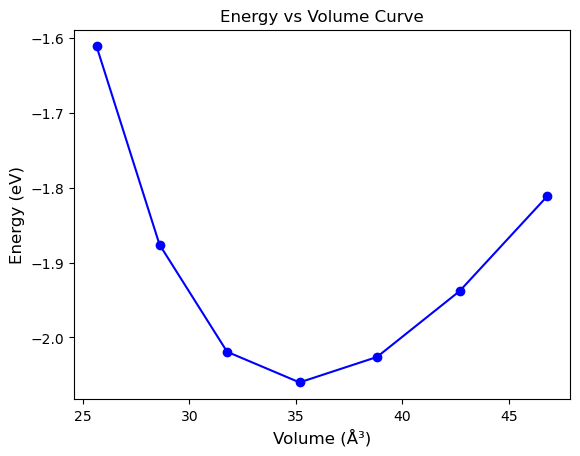

2025-03-13 23:15:27,581 - pyiron_log - INFO - Assigning a channel with the label E0 to the io key fit_eos__E0
2025-03-13 23:15:27,582 - pyiron_log - INFO - Assigning a channel with the label V0 to the io key fit_eos__V0
2025-03-13 23:15:27,583 - pyiron_log - INFO - Assigning a channel with the label B0_GPa to the io key fit_eos__B0_GPa
2025-03-13 23:15:27,585 - pyiron_log - INFO - Assigning a channel with the label None to the io key plot_ev_curve__None
2025-03-13 23:15:27,586 - pyiron_log - INFO - Assigning a channel with the label E0 to the io key fit_eos__E0
2025-03-13 23:15:27,587 - pyiron_log - INFO - Assigning a channel with the label V0 to the io key fit_eos__V0
2025-03-13 23:15:27,589 - pyiron_log - INFO - Assigning a channel with the label B0_GPa to the io key fit_eos__B0_GPa
2025-03-13 23:15:27,590 - pyiron_log - INFO - Assigning a channel with the label None to the io key plot_ev_curve__None
2025-03-13 23:15:27,591 - pyiron_log - INFO - Assigning a channel with the label E0 

Equilibrium Energy (E0): -2.0593558699161307
Equilibrium Volume (V0): 35.22917753738744
Bulk Modulus (B0): 33.287125029494504


In [11]:
wf = make_murnaghan_workflow("Ca_workflow1",
                             element_str="Ca",
                             potential_path = "potentials/Ca_Mg_linear_potential.yace",
                             delete_existing_savefiles=True)

# run the workflow
wf.run()

# print the output values
print("Equilibrium Energy (E0):", wf.outputs["fit_eos__E0"].value)
print("Equilibrium Volume (V0):", wf.outputs["fit_eos__V0"].value)
print("Bulk Modulus (B0):", wf.outputs["fit_eos__B0_GPa"].value)

#### GUI

A powerful feature of `pyiron_workflow` is its interactive GUI, which lets you visualize the entire workflow. Through this interface, you can easily inspect the individual nodes and their connections, as well as modify them—either one node at a time or adjust how they interact with each other.


In [12]:
from pyironflow import PyironFlow

pf = PyironFlow([wf])

In [13]:
pf.gui

## Generate Multiple Workflows to Compare Different Potentials over Multiple Structures

Now that we have established how to create a workflow for a given structure and potential, we can extend this approach to explore a variety of cases. In this section, we generate multiple workflows by iterating over three different structures—Ca-fcc, Mg-hcp, and a CaMg phase (sourced from the [Materials Project](https://next-gen.materialsproject.org/materials/mp-1039120/))—and testing them against various potentials.

Once these workflows are created, we can run them and then iterate over the results to produce comparison plots. This comprehensive analysis enables us to assess the performance of different potentials across multiple phases.


2025-03-13 23:15:27,777 - pyiron_log - INFO - Assigning a channel with the label name to the io key build_structure__name
2025-03-13 23:15:27,779 - pyiron_log - INFO - Assigning a channel with the label crystalstructure to the io key build_structure__crystalstructure
2025-03-13 23:15:27,780 - pyiron_log - INFO - Assigning a channel with the label a to the io key build_structure__a
2025-03-13 23:15:27,781 - pyiron_log - INFO - Assigning a channel with the label c to the io key build_structure__c
2025-03-13 23:15:27,782 - pyiron_log - INFO - Assigning a channel with the label c_over_a to the io key build_structure__c_over_a
2025-03-13 23:15:27,783 - pyiron_log - INFO - Assigning a channel with the label u to the io key build_structure__u
2025-03-13 23:15:27,785 - pyiron_log - INFO - Assigning a channel with the label orthorhombic to the io key build_structure__orthorhombic
2025-03-13 23:15:27,786 - pyiron_log - INFO - Assigning a channel with the label cubic to the io key build_structure

      Step     Time          Energy          fmax
BFGS:    0 23:15:27       -1.917039        1.252495


2025-03-13 23:15:27,854 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    1 23:15:27       -1.977823        0.986753


2025-03-13 23:15:27,867 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    2 23:15:27       -2.049656        0.413941


2025-03-13 23:15:27,884 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    3 23:15:27       -2.059834        0.082518


2025-03-13 23:15:27,894 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    4 23:15:27       -2.060297        0.005461


2025-03-13 23:15:27,906 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,908 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,910 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,912 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,914 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,915 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,917 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,919 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,920 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,922 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,925 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,927 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:27,931 - pyiron_log - DEBUG - Not supported parameter used!

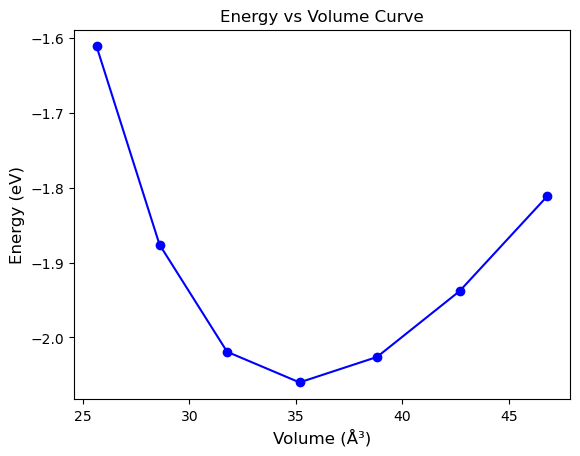

2025-03-13 23:15:28,086 - pyiron_log - INFO - Assigning a channel with the label E0 to the io key fit_eos__E0
2025-03-13 23:15:28,088 - pyiron_log - INFO - Assigning a channel with the label V0 to the io key fit_eos__V0
2025-03-13 23:15:28,090 - pyiron_log - INFO - Assigning a channel with the label B0_GPa to the io key fit_eos__B0_GPa
2025-03-13 23:15:28,090 - pyiron_log - INFO - Assigning a channel with the label None to the io key plot_ev_curve__None
2025-03-13 23:15:28,126 - pyiron_log - INFO - Assigning a channel with the label name to the io key build_structure__name
2025-03-13 23:15:28,127 - pyiron_log - INFO - Assigning a channel with the label crystalstructure to the io key build_structure__crystalstructure
2025-03-13 23:15:28,128 - pyiron_log - INFO - Assigning a channel with the label a to the io key build_structure__a
2025-03-13 23:15:28,129 - pyiron_log - INFO - Assigning a channel with the label c to the io key build_structure__c
2025-03-13 23:15:28,130 - pyiron_log - INF

Using cached GRACE model from /home/poul/.cache/grace/GRACE-1L-OAM
Model license: Academic Software License


/home/poul/pyiron/DPG-tutorial-2025/pyiron_nodes/atomistic/properties/murnaghan.py:34: FutureWarning: Import ExpCellFilter from ase.filters
  constrained_structure = ExpCellFilter(structure)
2025-03-13 23:15:31,230 - pyiron_log - DEBUG - Not supported parameter used!
I0000 00:00:1741904131.541099   13638 service.cc:145] XLA service 0x5558b61c60d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741904131.541173   13638 service.cc:153]   StreamExecutor device (0): Host, Default Version


      Step     Time          Energy          fmax
BFGS:    0 23:15:34       -1.989779        0.138848


I0000 00:00:1741904134.757161   13638 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-03-13 23:15:34,801 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    1 23:15:34       -1.990523        0.110709


2025-03-13 23:15:34,830 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    2 23:15:34       -1.991806        0.002090


2025-03-13 23:15:34,854 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:34,855 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:34,857 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:34,877 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:34,878 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:34,897 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:34,899 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:34,919 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:34,920 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:34,941 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:34,944 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:34,965 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:15:34,967 - pyiron_log - DEBUG - Not supported parameter used!

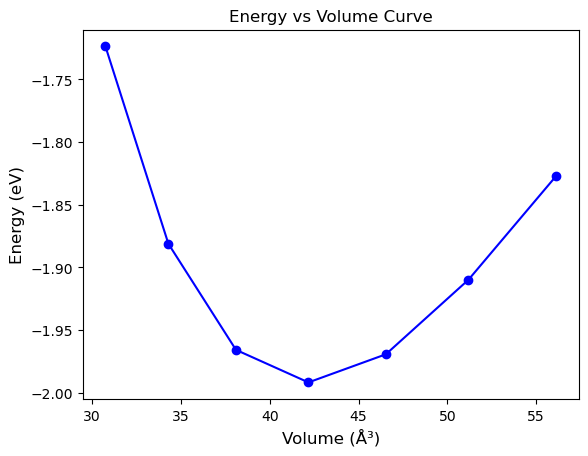

2025-03-13 23:15:35,092 - pyiron_log - INFO - Assigning a channel with the label E0 to the io key fit_eos__E0
2025-03-13 23:15:35,092 - pyiron_log - INFO - Assigning a channel with the label V0 to the io key fit_eos__V0
2025-03-13 23:15:35,093 - pyiron_log - INFO - Assigning a channel with the label B0_GPa to the io key fit_eos__B0_GPa
2025-03-13 23:15:35,094 - pyiron_log - INFO - Assigning a channel with the label None to the io key plot_ev_curve__None
2025-03-13 23:15:35,114 - pyiron_log - INFO - Assigning a channel with the label name to the io key build_structure__name
2025-03-13 23:15:35,115 - pyiron_log - INFO - Assigning a channel with the label crystalstructure to the io key build_structure__crystalstructure
2025-03-13 23:15:35,116 - pyiron_log - INFO - Assigning a channel with the label a to the io key build_structure__a
2025-03-13 23:15:35,116 - pyiron_log - INFO - Assigning a channel with the label c to the io key build_structure__c
2025-03-13 23:15:35,117 - pyiron_log - INF

Unpacking model from 'https://ruhr-uni-bochum.sciebo.de/s/4zVTfzxornWfS4T/download'
GRACE model downloaded to /home/poul/.cache/grace/GRACE-2L-OAM
Model license: Academic Software License


2025-03-13 23:15:52,976 - pyiron_log - DEBUG - Not supported parameter used!


      Step     Time          Energy          fmax
BFGS:    0 23:16:00       -1.990997        0.133988


2025-03-13 23:16:00,662 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    1 23:16:00       -1.991691        0.107684


2025-03-13 23:16:00,725 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    2 23:16:00       -1.992947        0.001825


2025-03-13 23:16:00,788 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:00,790 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:00,793 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:00,849 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:00,850 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:00,904 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:00,906 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:00,953 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:00,955 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:01,006 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:01,007 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:01,060 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:01,061 - pyiron_log - DEBUG - Not supported parameter used!

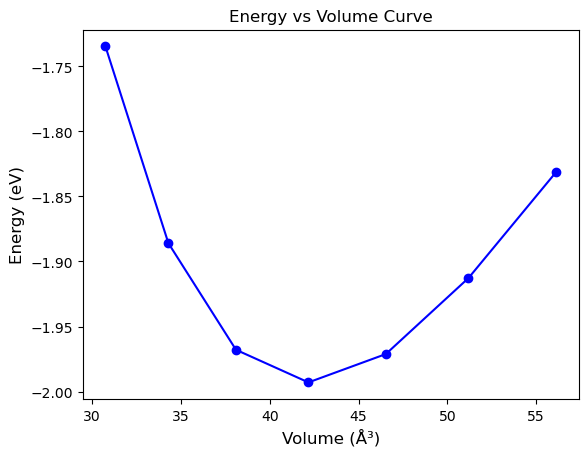

2025-03-13 23:16:01,274 - pyiron_log - INFO - Assigning a channel with the label E0 to the io key fit_eos__E0
2025-03-13 23:16:01,274 - pyiron_log - INFO - Assigning a channel with the label V0 to the io key fit_eos__V0
2025-03-13 23:16:01,276 - pyiron_log - INFO - Assigning a channel with the label B0_GPa to the io key fit_eos__B0_GPa
2025-03-13 23:16:01,276 - pyiron_log - INFO - Assigning a channel with the label None to the io key plot_ev_curve__None
2025-03-13 23:16:01,298 - pyiron_log - INFO - Assigning a channel with the label potential_file to the io key Calculator__potential_file
2025-03-13 23:16:01,299 - pyiron_log - INFO - Assigning a channel with the label structure to the io key optimize_structure__structure
2025-03-13 23:16:01,300 - pyiron_log - INFO - Assigning a channel with the label potential_file to the io key Calculator__potential_file
2025-03-13 23:16:01,301 - pyiron_log - INFO - Assigning a channel with the label structure to the io key optimize_structure__structur

      Step     Time          Energy          fmax
BFGS:    0 23:16:01       -6.677221        3.238830
BFGS:    1 23:16:01       -6.803734        0.604423
BFGS:    2 23:16:01       -6.807127        0.110940
BFGS:    3 23:16:01       -6.808211        0.129854
BFGS:    4 23:16:01       -6.810284        0.138164
BFGS:    5 23:16:01       -6.810686        0.092782
BFGS:    6 23:16:01       -6.811026        0.069524
BFGS:    7 23:16:01       -6.811137        0.061313
BFGS:    8 23:16:01       -6.811208        0.027982
BFGS:    9 23:16:01       -6.811234        0.017905
BFGS:   10 23:16:01       -6.811250        0.014216
BFGS:   11 23:16:01       -6.811267        0.015092
BFGS:   12 23:16:01       -6.811308        0.036424
BFGS:   13 23:16:01       -6.811427        0.086343
BFGS:   14 23:16:01       -6.812652        0.267225
BFGS:   15 23:16:01       -6.823384        0.279244
BFGS:   16 23:16:01       -6.872346        0.411273
BFGS:   17 23:16:01       -7.064335        1.058251
BFGS:   18 23:

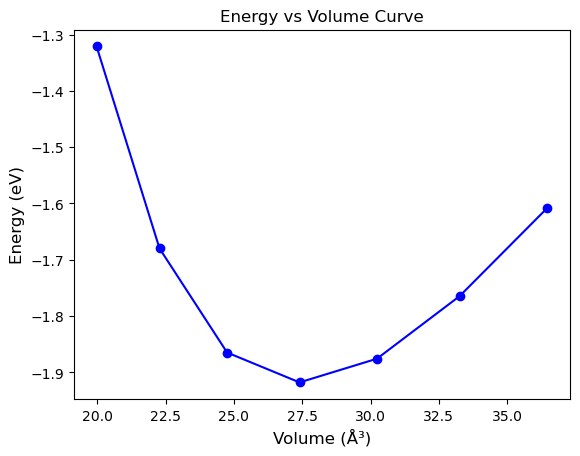

2025-03-13 23:16:01,790 - pyiron_log - INFO - Assigning a channel with the label E0 to the io key fit_eos__E0
2025-03-13 23:16:01,791 - pyiron_log - INFO - Assigning a channel with the label V0 to the io key fit_eos__V0
2025-03-13 23:16:01,792 - pyiron_log - INFO - Assigning a channel with the label B0_GPa to the io key fit_eos__B0_GPa
2025-03-13 23:16:01,793 - pyiron_log - INFO - Assigning a channel with the label None to the io key plot_ev_curve__None
2025-03-13 23:16:01,811 - pyiron_log - INFO - Assigning a channel with the label model to the io key Calculator__model
2025-03-13 23:16:01,812 - pyiron_log - INFO - Assigning a channel with the label structure to the io key optimize_structure__structure
2025-03-13 23:16:01,813 - pyiron_log - INFO - Assigning a channel with the label model to the io key Calculator__model
2025-03-13 23:16:01,813 - pyiron_log - INFO - Assigning a channel with the label structure to the io key optimize_structure__structure
2025-03-13 23:16:01,814 - pyiron_l

Using cached GRACE model from /home/poul/.cache/grace/GRACE-1L-OAM
Model license: Academic Software License
      Step     Time          Energy          fmax
BFGS:    0 23:16:05       -7.022948        0.386057
BFGS:    1 23:16:05       -7.026133        0.292071
BFGS:    2 23:16:05       -7.031331        0.058989
BFGS:    3 23:16:05       -7.031437        0.038634
BFGS:    4 23:16:05       -7.031472        0.011031
BFGS:    5 23:16:05       -7.031478        0.007018


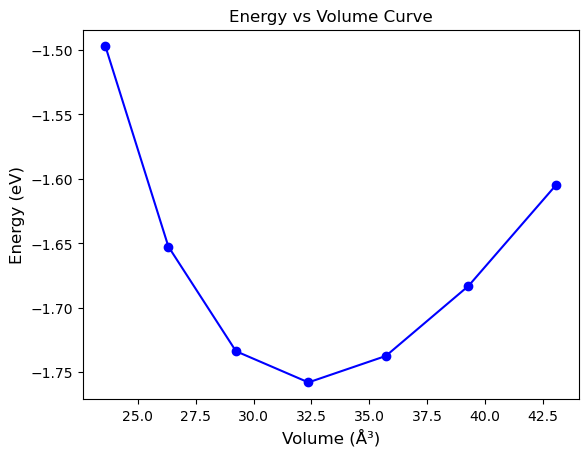

2025-03-13 23:16:06,219 - pyiron_log - INFO - Assigning a channel with the label E0 to the io key fit_eos__E0
2025-03-13 23:16:06,220 - pyiron_log - INFO - Assigning a channel with the label V0 to the io key fit_eos__V0
2025-03-13 23:16:06,221 - pyiron_log - INFO - Assigning a channel with the label B0_GPa to the io key fit_eos__B0_GPa
2025-03-13 23:16:06,221 - pyiron_log - INFO - Assigning a channel with the label None to the io key plot_ev_curve__None
2025-03-13 23:16:06,236 - pyiron_log - INFO - Assigning a channel with the label model to the io key Calculator__model
2025-03-13 23:16:06,237 - pyiron_log - INFO - Assigning a channel with the label structure to the io key optimize_structure__structure
2025-03-13 23:16:06,238 - pyiron_log - INFO - Assigning a channel with the label model to the io key Calculator__model
2025-03-13 23:16:06,240 - pyiron_log - INFO - Assigning a channel with the label structure to the io key optimize_structure__structure
2025-03-13 23:16:06,240 - pyiron_l

Using cached GRACE model from /home/poul/.cache/grace/GRACE-2L-OAM
Model license: Academic Software License
      Step     Time          Energy          fmax
BFGS:    0 23:16:15       -7.026683        0.477407
BFGS:    1 23:16:15       -7.031136        0.364614
BFGS:    2 23:16:15       -7.039724        0.047764
BFGS:    3 23:16:15       -7.039900        0.023796
BFGS:    4 23:16:15       -7.039921        0.024307
BFGS:    5 23:16:15       -7.040006        0.023365
BFGS:    6 23:16:15       -7.040118        0.028605
BFGS:    7 23:16:15       -7.040249        0.026071
BFGS:    8 23:16:15       -7.040324        0.028047
BFGS:    9 23:16:15       -7.040367        0.027824
BFGS:   10 23:16:15       -7.040424        0.026288
BFGS:   11 23:16:15       -7.040567        0.054084
BFGS:   12 23:16:15       -7.040941        0.102767
BFGS:   13 23:16:15       -7.042368        0.219061
BFGS:   14 23:16:16       -7.048425        0.305472
BFGS:   15 23:16:16       -7.105974        0.643268
BFGS:   16

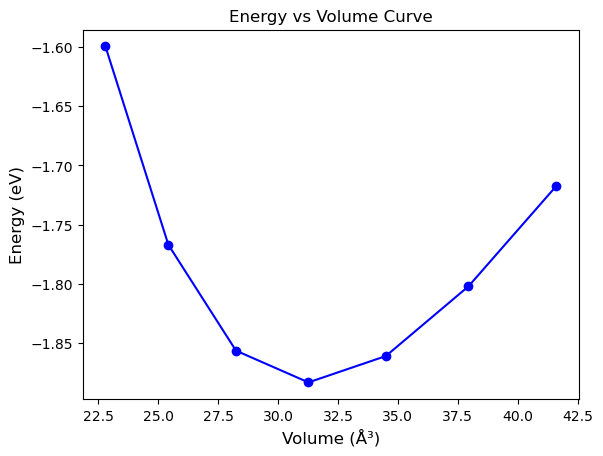

2025-03-13 23:16:17,829 - pyiron_log - INFO - Assigning a channel with the label E0 to the io key fit_eos__E0
2025-03-13 23:16:17,830 - pyiron_log - INFO - Assigning a channel with the label V0 to the io key fit_eos__V0
2025-03-13 23:16:17,831 - pyiron_log - INFO - Assigning a channel with the label B0_GPa to the io key fit_eos__B0_GPa
2025-03-13 23:16:17,832 - pyiron_log - INFO - Assigning a channel with the label None to the io key plot_ev_curve__None
2025-03-13 23:16:17,855 - pyiron_log - INFO - Assigning a channel with the label name to the io key build_structure__name
2025-03-13 23:16:17,856 - pyiron_log - INFO - Assigning a channel with the label crystalstructure to the io key build_structure__crystalstructure
2025-03-13 23:16:17,857 - pyiron_log - INFO - Assigning a channel with the label a to the io key build_structure__a
2025-03-13 23:16:17,858 - pyiron_log - INFO - Assigning a channel with the label c to the io key build_structure__c
2025-03-13 23:16:17,859 - pyiron_log - INF

      Step     Time          Energy          fmax
BFGS:    0 23:16:18       -3.127319        2.179369


2025-03-13 23:16:18,137 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    1 23:16:18       -3.276902        1.177010


2025-03-13 23:16:18,173 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    2 23:16:18       -3.307763        0.612279


2025-03-13 23:16:18,188 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    3 23:16:18       -3.314935        0.115422


2025-03-13 23:16:18,200 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    4 23:16:18       -3.315312        0.078219


2025-03-13 23:16:18,213 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    5 23:16:18       -3.315492        0.026852


2025-03-13 23:16:18,225 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    6 23:16:18       -3.315502        0.004866


2025-03-13 23:16:18,233 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:18,235 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:18,237 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:18,239 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:18,241 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:18,243 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:18,244 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:18,246 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:18,247 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:18,249 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:18,251 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:18,253 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:18,254 - pyiron_log - DEBUG - Not supported parameter used!

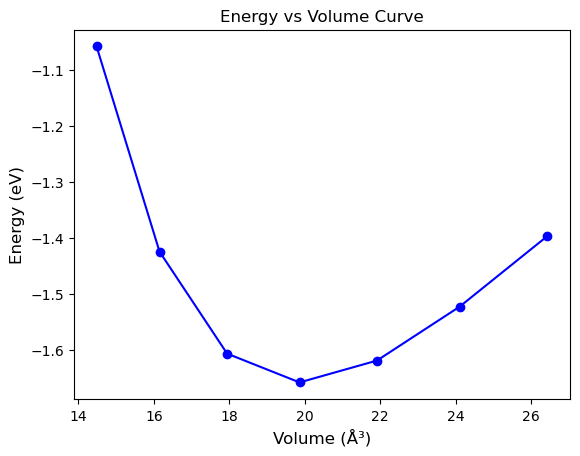

2025-03-13 23:16:18,340 - pyiron_log - INFO - Assigning a channel with the label E0 to the io key fit_eos__E0
2025-03-13 23:16:18,340 - pyiron_log - INFO - Assigning a channel with the label V0 to the io key fit_eos__V0
2025-03-13 23:16:18,342 - pyiron_log - INFO - Assigning a channel with the label B0_GPa to the io key fit_eos__B0_GPa
2025-03-13 23:16:18,343 - pyiron_log - INFO - Assigning a channel with the label None to the io key plot_ev_curve__None
2025-03-13 23:16:18,363 - pyiron_log - INFO - Assigning a channel with the label name to the io key build_structure__name
2025-03-13 23:16:18,363 - pyiron_log - INFO - Assigning a channel with the label crystalstructure to the io key build_structure__crystalstructure
2025-03-13 23:16:18,364 - pyiron_log - INFO - Assigning a channel with the label a to the io key build_structure__a
2025-03-13 23:16:18,365 - pyiron_log - INFO - Assigning a channel with the label c to the io key build_structure__c
2025-03-13 23:16:18,365 - pyiron_log - INF

Using cached GRACE model from /home/poul/.cache/grace/GRACE-1L-OAM
Model license: Academic Software License


2025-03-13 23:16:19,206 - pyiron_log - DEBUG - Not supported parameter used!


      Step     Time          Energy          fmax
BFGS:    0 23:16:22       -3.200998        0.219709


2025-03-13 23:16:22,294 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    1 23:16:22       -3.202222        0.133449


2025-03-13 23:16:22,321 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    2 23:16:22       -3.202828        0.010702


2025-03-13 23:16:22,350 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    3 23:16:22       -3.202833        0.010174


2025-03-13 23:16:22,380 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    4 23:16:22       -3.202840        0.003399


2025-03-13 23:16:22,407 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:22,408 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:22,410 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:22,430 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:22,432 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:22,456 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:22,458 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:22,483 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:22,485 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:22,506 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:22,508 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:22,533 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:22,535 - pyiron_log - DEBUG - Not supported parameter used!

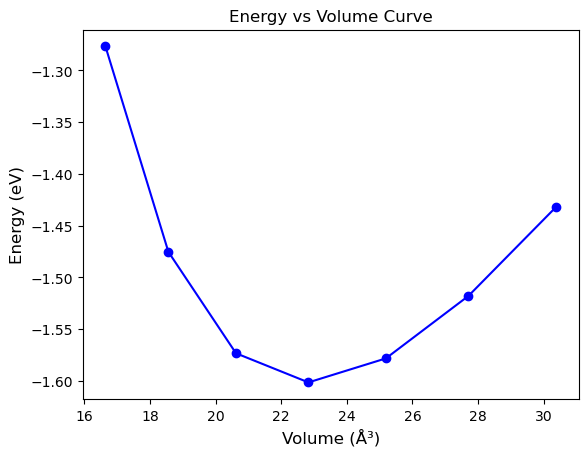

2025-03-13 23:16:22,658 - pyiron_log - INFO - Assigning a channel with the label E0 to the io key fit_eos__E0
2025-03-13 23:16:22,659 - pyiron_log - INFO - Assigning a channel with the label V0 to the io key fit_eos__V0
2025-03-13 23:16:22,660 - pyiron_log - INFO - Assigning a channel with the label B0_GPa to the io key fit_eos__B0_GPa
2025-03-13 23:16:22,661 - pyiron_log - INFO - Assigning a channel with the label None to the io key plot_ev_curve__None
2025-03-13 23:16:22,681 - pyiron_log - INFO - Assigning a channel with the label name to the io key build_structure__name
2025-03-13 23:16:22,681 - pyiron_log - INFO - Assigning a channel with the label crystalstructure to the io key build_structure__crystalstructure
2025-03-13 23:16:22,682 - pyiron_log - INFO - Assigning a channel with the label a to the io key build_structure__a
2025-03-13 23:16:22,683 - pyiron_log - INFO - Assigning a channel with the label c to the io key build_structure__c
2025-03-13 23:16:22,683 - pyiron_log - INF

Using cached GRACE model from /home/poul/.cache/grace/GRACE-2L-OAM
Model license: Academic Software License


2025-03-13 23:16:23,875 - pyiron_log - DEBUG - Not supported parameter used!


      Step     Time          Energy          fmax
BFGS:    0 23:16:31       -3.201405        0.234211


2025-03-13 23:16:31,246 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    1 23:16:31       -3.202728        0.143308


2025-03-13 23:16:31,314 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    2 23:16:31       -3.203364        0.015907


2025-03-13 23:16:31,375 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    3 23:16:31       -3.203373        0.014474


2025-03-13 23:16:31,440 - pyiron_log - DEBUG - Not supported parameter used!


BFGS:    4 23:16:31       -3.203391        0.000810


2025-03-13 23:16:31,499 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:31,501 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:31,502 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:31,555 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:31,557 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:31,606 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:31,608 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:31,660 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:31,662 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:31,718 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:31,719 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:31,777 - pyiron_log - DEBUG - Not supported parameter used!
2025-03-13 23:16:31,779 - pyiron_log - DEBUG - Not supported parameter used!

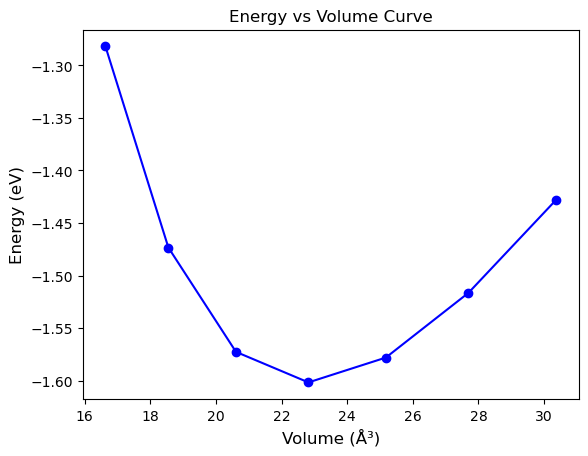

2025-03-13 23:16:32,002 - pyiron_log - INFO - Assigning a channel with the label E0 to the io key fit_eos__E0
2025-03-13 23:16:32,003 - pyiron_log - INFO - Assigning a channel with the label V0 to the io key fit_eos__V0
2025-03-13 23:16:32,003 - pyiron_log - INFO - Assigning a channel with the label B0_GPa to the io key fit_eos__B0_GPa
2025-03-13 23:16:32,004 - pyiron_log - INFO - Assigning a channel with the label None to the io key plot_ev_curve__None


In [14]:
import os
import matplotlib.pyplot as plt


# Structure labels as element-strings: (the actual atomic structures are generated within the workflow)
struc_labels = ["Ca", "CaMg", "Mg",]

# Define potential paths and assign labels (these labels will be part of the workflow name)
potentials = {
    'LinearACE': "potentials/Ca_Mg_linear_potential.yace",
    # "ACE_nfuncs_10": "potentials/Bad_linear_potential.yace",
    # "ACE_nfuncs_50": "potentials/Better_potential.yace",
    # "GRACE_1L_r6": "MP_GRACE_1L_r6_07Nov2024",
    "GRACE_1L_OAM": "GRACE-1L-OAM",
    "GRACE_2L_OAM" : "GRACE-2L-OAM"
}

# Create an empty dictionary to store the workflows:
workflows = {}

# Loop over all structure and potential combinations:
for struc_label in struc_labels:
    for pot_label, pot_path in potentials.items():
        
        # Create a unique workflow name
        wf_name = f"{struc_label}_{pot_label}"
        
        wf = make_murnaghan_workflow(
            workflow_name=wf_name,
            element_str=struc_label,
            potential_path=pot_path,
            delete_existing_savefiles=True
        )
        # Set the structure input (other inputs like fmax, max_steps, etc. can be set here as needed)
        # wf.inputs.structure = structure
        
        # Run the workflow.
        wf.run()
        
        # Save the workflow object for later analysis/plotting.
        workflows[wf_name] = wf

In [15]:
workflows

{'Ca_LinearACE': <pyiron_workflow.workflow.Workflow at 0x7fc888b9c0d0>,
 'Ca_GRACE_1L_OAM': <pyiron_workflow.workflow.Workflow at 0x7fc888b36a10>,
 'Ca_GRACE_2L_OAM': <pyiron_workflow.workflow.Workflow at 0x7fc888b738d0>,
 'CaMg_LinearACE': <pyiron_workflow.workflow.Workflow at 0x7fc7d0303a50>,
 'CaMg_GRACE_1L_OAM': <pyiron_workflow.workflow.Workflow at 0x7fc81c7ceed0>,
 'CaMg_GRACE_2L_OAM': <pyiron_workflow.workflow.Workflow at 0x7fc81c142510>,
 'Mg_LinearACE': <pyiron_workflow.workflow.Workflow at 0x7fc814342210>,
 'Mg_GRACE_1L_OAM': <pyiron_workflow.workflow.Workflow at 0x7fc7807a6d10>,
 'Mg_GRACE_2L_OAM': <pyiron_workflow.workflow.Workflow at 0x7fc7786ac390>}

In [16]:
# DFT references taken from https://doi.org/10.1103/PhysRevB.107.104103

ref_e0 = {"Ca": -1.930,
          "Mg" : -1.506,
          "CaMg" : -1.802}

ref_V = {"Ca": 42.193,
          "Mg" : 22.953,
          "CaMg" : 30.939}

Ca_LinearACE
Ca_GRACE_1L_OAM
Ca_GRACE_2L_OAM
CaMg_LinearACE
CaMg_GRACE_1L_OAM
CaMg_GRACE_2L_OAM
Mg_LinearACE
Mg_GRACE_1L_OAM
Mg_GRACE_2L_OAM


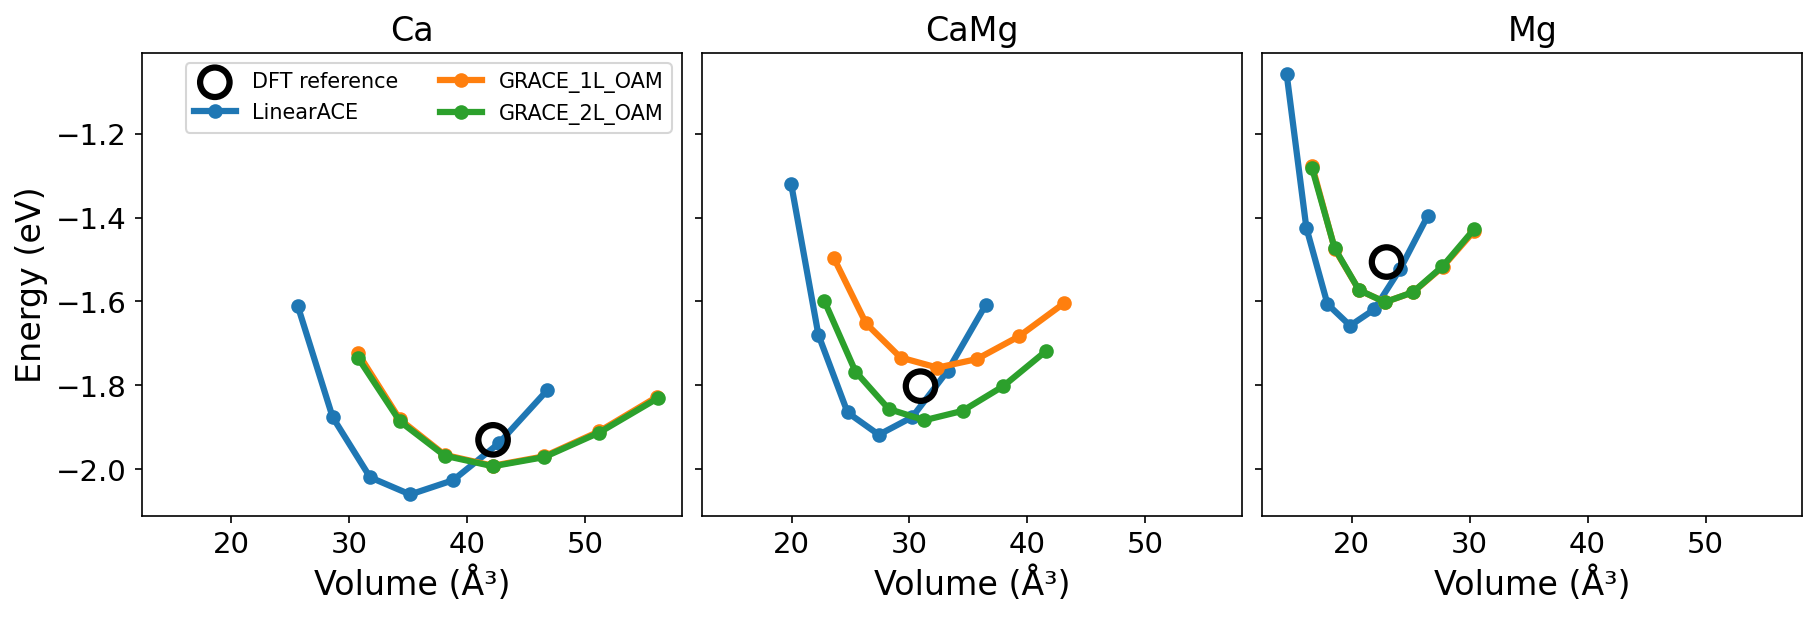

In [17]:
fontsize = 16

fig, ax_list = plt.subplots(ncols=3, dpi=150, sharex=True, sharey=True, figsize=(12,4), constrained_layout=True)

ii = 0
for ii, struc_label in enumerate(struc_labels):
    ax = ax_list[ii]
    ii += 1

    ref_e = ref_e0[struc_label]
    ref_v = ref_V[struc_label]
    # ax.axhline(ref_e, ls="--", label="DFT reference")
    ax.scatter(ref_v,ref_e, 
               marker="o",
               s=200,
               facecolor="None",
               edgecolor="k",
               lw=3,
               zorder=5,
               label="DFT reference"
              )

    
    for jj,pot_label in enumerate(potentials.keys()):
        wf_name = f"{struc_label}_{pot_label}"
        print(wf_name)

        wf = workflows[wf_name]
        df = wf.calculate_ev_curve.outputs.df.value
        
        ax.plot(df['volume'], df['energy'],
                'o-', 
                lw=3,
                label=f"{pot_label}")
        ax.set_xlabel("Volume (Å³)",fontsize=fontsize)
        ax.tick_params(labelsize=fontsize-2)
        ax.set_title(struc_label,fontsize=fontsize)
        


ax_list[0].set_ylabel("Energy (eV)",fontsize=fontsize)
ax_list[0].legend(prop={"size":fontsize-6}, ncol=2)

# plt.tight_layout()
plt.show()

Thus we can neatly compare the different potentials with DFT references. For the above plots, the DFT references are taken from [Poul et. al.](https://doi.org/10.1103/PhysRevB.107.104103) 

In [18]:
# DFT references taken from https://doi.org/10.1103/PhysRevB.107.104103

ref_B0 = {"Ca": 17.500,
          "CaMg" : 25.769,
          "Mg" : 36.434,
          }

2025-03-13 23:16:32,484 - pyiron_log - INFO - Assigning a channel with the label E0 to the io key fit_eos__E0
2025-03-13 23:16:32,486 - pyiron_log - INFO - Assigning a channel with the label V0 to the io key fit_eos__V0
2025-03-13 23:16:32,487 - pyiron_log - INFO - Assigning a channel with the label B0_GPa to the io key fit_eos__B0_GPa
2025-03-13 23:16:32,488 - pyiron_log - INFO - Assigning a channel with the label None to the io key plot_ev_curve__None
2025-03-13 23:16:32,489 - pyiron_log - INFO - Assigning a channel with the label E0 to the io key fit_eos__E0
2025-03-13 23:16:32,490 - pyiron_log - INFO - Assigning a channel with the label V0 to the io key fit_eos__V0
2025-03-13 23:16:32,492 - pyiron_log - INFO - Assigning a channel with the label B0_GPa to the io key fit_eos__B0_GPa
2025-03-13 23:16:32,494 - pyiron_log - INFO - Assigning a channel with the label None to the io key plot_ev_curve__None
2025-03-13 23:16:32,495 - pyiron_log - INFO - Assigning a channel with the label E0 

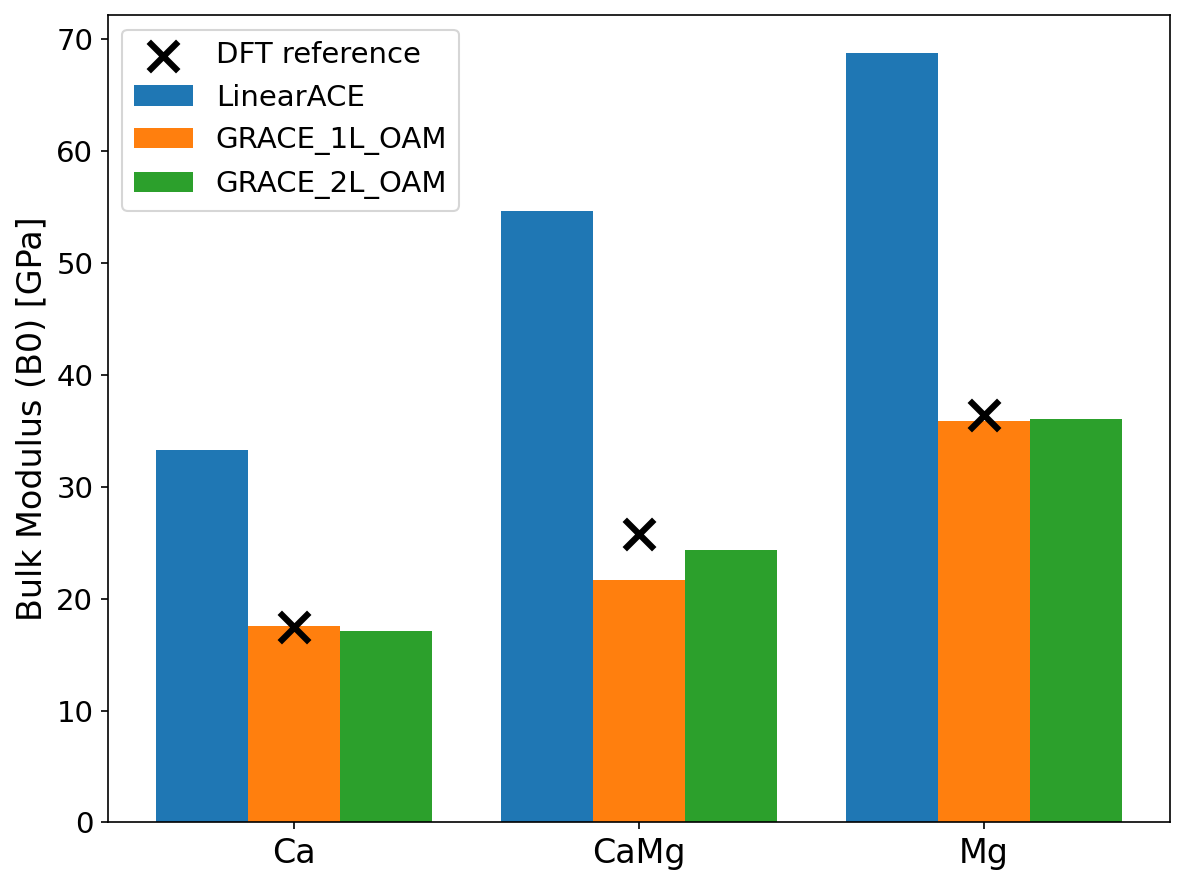

In [19]:
import numpy as np
import matplotlib.pyplot as plt

fontsize = 16

# Define the order of structures and potentials.
structures = list(struc_labels)  
pot_labels = list(potentials.keys())   

B0_values = []  # rows: structures, columns: potentials

for struc_label in structures:
    B0_row = []
    for pot_label in pot_labels:
        wf_name = f"{struc_label}_{pot_label}"
        wf = workflows[wf_name]
        # Assuming your FitBirchMurnaghanEOS node returns a dictionary mapped to 'eos'
        B0 = wf.outputs["fit_eos__B0_GPa"].value
        B0_row.append(B0)
    B0_values.append(B0_row)

B0_values = np.array(B0_values)  # Shape: (n_structures, n_potentials)

# Plotting a grouped bar chart.
fig, ax = plt.subplots(dpi=150, figsize=(8, 6))

n_groups = len(structures)
n_bars = len(pot_labels)
index = np.arange(n_groups)  # positions for groups on the x-

ax.scatter(index, ref_B0.values(),
           marker="x",
           s=200,
           color="k",
           label="DFT reference",
           lw=3,
           zorder=5,
          )

total_group_width = 0.8  
bar_width = total_group_width / n_bars  

for i, pot_label in enumerate(pot_labels):
    # Compute offset so that bars are centered on each group position.
    offset = (i - (n_bars - 1) / 2) * bar_width
    ax.bar(index + offset, B0_values[:, i], bar_width, label=pot_label)

ax.set_ylabel("Bulk Modulus (B0) [GPa]", fontsize=fontsize)
ax.set_xticks(index)
ax.set_xticklabels(structures, fontsize=fontsize)
ax.tick_params(axis="y", labelsize=fontsize-2)
ax.legend(fontsize=fontsize-2)

plt.tight_layout()
plt.show()


DFT references are taken from [Poul et. al.](https://doi.org/10.1103/PhysRevB.107.104103) 